In [1]:
import tensorflow as tf
import csv
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import imghdr
import IPython.display as display


In [17]:
(x_train, y_train) , (x_test,y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")


(60000, 28, 28)
(60000, 28, 28, 1)


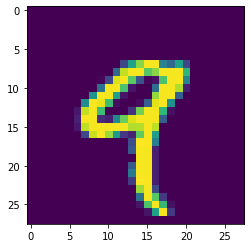

In [24]:
img=x_train[4]
plt.imshow(img)
print(x_train.shape)
X = x_train.reshape(x_train.shape[0],28,28,1)
X = X.astype('float32')
X /= 255
print(X.shape)
Z = x_test.reshape(x_test.shape[0],28,28,1)
Z = Z.astype('float32')
Z/=255


In [10]:
#creating the model
model = tf.keras.Sequential()
model.add(Conv2D(32, kernel_size=(3,3), padding='same', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(3,3), padding='same'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(80, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

In [236]:
model.compile(optimizer='adam', metrics=['sparse_categorical_accuracy'], loss='sparse_categorical_crossentropy')

In [238]:
model.fit(X,y_train, epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 139us/sample - loss: 0.3848 - sparse_categorical_accuracy: 0.8820
Epoch 2/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.1621 - sparse_categorical_accuracy: 0.9542
Epoch 3/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.1324 - sparse_categorical_accuracy: 0.9631
Epoch 4/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.1134 - sparse_categorical_accuracy: 0.9682
Epoch 5/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.0982 - sparse_categorical_accuracy: 0.9720
Epoch 6/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.0925 - sparse_categorical_accuracy: 0.9731
Epoch 7/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.0872 - sparse_categorical_accuracy: 0.9746
Epoch 8/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.0808 - spar

In [239]:
model.evaluate(Z,y_test)

10000/10000 [==============================] - 1s 69us/sample - loss: 0.0531 - sparse_categorical_accuracy: 0.9841


[0.05307253737012234, 0.9841]

In [18]:
# This is the working tfrecords.

#helper functions:

def _int64_feature(value):
#Wrapper for inserting int64 features into Example proto.
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


#This is unnecesary for the features i used
#however if i wanted to create a tfrecords file
#from pictures this would be necessary for the
#image_raw feature.
def _bytes_feature(value):
#Wrapper for inserting bytes features into Example proto.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


# Create a dictionary with the relevant features.
def image_example(img, label):
    #image_shape = tf.image.decode_jpeg(image_string).shape #this is to decode the bytes into a workable shape - for pictures
    feature = {
          'height': _int64_feature(img.shape[0]),
          'width': _int64_feature(img.shape[1]),
          'depth': _int64_feature(img.shape[2]),
          'label': _int64_feature(label),
          'image_raw': _bytes_feature(image_string), 
      }

    return tf.train.Example(features=tf.train.Features(feature=feature))

#dictionary sanity check
image = x_train[0].reshape(28,28,1).astype('float32')
lbl = y_train[0]

for line in str(image_example(image, lbl)).split('\n')[:30]:
    print(line)
print('...')


features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 28
      }
    }
  }
  feature {
    key: "label"
    value {
      int64_list {
        value: 5
      }
    }
  }
  feature {
    key: "width"
    value {
      int64_list {
        value: 28
...


In [12]:
#reshape the training data and normalize
images = x_train.reshape(x_train.shape[0],28,28,1)
images = images.astype('float32')
images /= 255
num_train = images.shape[0]

# Write the raw image files to `mnist.tfrecords`.
# First, process the data into `tf.Example` messages.
# Then, write to a `.tfrecords` file.
record_file = 'mnist.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
    for i in range(num_train):
        tf_example = image_example(images[i], y_train[i])
        writer.write(tf_example.SerializeToString())
writer.close()

In [13]:
#create a dataset using the newly created tfrecords file
raw_dataset = tf.data.TFRecordDataset(filenames = 'mnist.tfrecords')
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [16]:
# Create a description of the features.
feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'width': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'depth': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'label': tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def _parse_function(example_proto):
  # Parse the input `tf.Example` proto using the dictionary above.
  return tf.io.parse_example(example_proto, feature_description)

def create_dataset(dataset):
    dataset=dataset.map(_parse_function)
    dataset = dataset.batch(64)
    return dataset

dataset = create_dataset(raw_dataset)
dataset = dataset.take(1)
list(dataset.as_numpy_iterator())

    
    
   # dataset= dataset.repeat()
   # dataset = dataset.shuffle(100)
   # image, label = dataset.get_next()
   # image = tf.reshape(image, [-1,28,28,1])
   # label = tf.one_hot(label, 9)
   # return image,label


[{'depth': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        dtype=int64),
  'height': array([28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
         28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
         28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
         28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28], dtype=int64),
  'label': array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
         9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
         3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0],
        dtype=int64),
  'width': array([28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
         28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
         28, 28, 2

In [268]:
#create a dataset using the newly created tfrecords file
dataset = tf.data.TFRecordDataset(filenames = 'mnist.tfrecords')
dataset
image, label = create_dataset(dataset)


ValueError: too many values to unpack (expected 2)

In [78]:
from pathlib import Path

folder = 0

data_folder = Path("mnist data/trainingSet/trainingSet/%d" %folder)

file = data_folder / "img_1.jpg"

f = open(file,'rb').read()

imshape = tf.image.decode_jpeg(f).shape

print(imshape)

(28, 28, 1)


In [79]:
import os
from pathlib import Path

def _int64_feature(value):
#Wrapper for inserting int64 features into Example proto.
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def _bytes_feature(value):
#Wrapper for inserting bytes features into Example proto.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def image_example(image_string, label):
    image_shape = tf.image.decode_jpeg(image_string).shape
    feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string),
  }

    return tf.train.Example(features=tf.train.Features(feature=feature))


record_file = 'test.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
    for i in range(10):
        folder = i
        data_folder = Path("mnist data/trainingSample/trainingSample/%d" %folder)
        directory = os.fsencode(data_folder)
        for file in os.listdir(directory):
            filename = data_folder / os.fsdecode(file)
            image_string = open(filename,'rb').read()
            label = folder
            tf_example = image_example(image_string, label)
            writer.write(tf_example.SerializeToString())
for line in str(image_example(image_string, label)).split('\n')[:15]:
    print(line)
print('...')




features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 28
      }
...


In [103]:
raw_image_dataset = tf.data.TFRecordDataset('test.tfrecords')

# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
    # Parse the input tf.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {depth: (), height: (), image_raw: (), label: (), width: ()}, types: {depth: tf.int64, height: tf.int64, image_raw: tf.string, label: tf.int64, width: tf.int64}>

In [111]:
for image_features in parsed_image_dataset:
    #image_raw = image_features['image_raw'].numpy()
    #display.display(display.Image(data=image_raw))
    image = tf.io.decode_raw(image_features['image_raw'], tf.uint8)
    #image.set_shape([28 * 28])
    #image = tf.cast(image, tf.float32)*(1. / 255)
    #image = tf.reshape(image,[28,28,1])
    label = tf.cast(image_features['label'],tf.uint64)
    label = tf.squeeze(label)
    print(image)


tf.Tensor(
[255 216 255 224   0  16  74  70  73  70   0   1   1   0   0   1   0   1
   0   0 255 219   0  67   0   8   6   6   7   6   5   8   7   7   7   9
   9   8  10  12  20  13  12  11  11  12  25  18  19  15  20  29  26  31
  30  29  26  28  28  32  36  46  39  32  34  44  35  28  28  40  55  41
  44  48  49  52  52  52  31  39  57  61  56  50  60  46  51  52  50 255
 192   0  11   8   0  28   0  28   1   1  17   0 255 196   0  31   0   0
   1   5   1   1   1   1   1   1   0   0   0   0   0   0   0   0   1   2
   3   4   5   6   7   8   9  10  11 255 196   0 181  16   0   2   1   3
   3   2   4   3   5   5   4   4   0   0   1 125   1   2   3   0   4  17
   5  18  33  49  65   6  19  81  97   7  34 113  20  50 129 145 161   8
  35  66 177 193  21  82 209 240  36  51  98 114 130   9  10  22  23  24
  25  26  37  38  39  40  41  42  52  53  54  55  56  57  58  67  68  69
  70  71  72  73  74  83  84  85  86  87  88  89  90  99 100 101 102 103
 104 105 106 115 116 117 118 119 120 121

 175 255 217], shape=(543,), dtype=uint8)
tf.Tensor(
[255 216 255 224   0  16  74  70  73  70   0   1   1   0   0   1   0   1
   0   0 255 219   0  67   0   8   6   6   7   6   5   8   7   7   7   9
   9   8  10  12  20  13  12  11  11  12  25  18  19  15  20  29  26  31
  30  29  26  28  28  32  36  46  39  32  34  44  35  28  28  40  55  41
  44  48  49  52  52  52  31  39  57  61  56  50  60  46  51  52  50 255
 192   0  11   8   0  28   0  28   1   1  17   0 255 196   0  31   0   0
   1   5   1   1   1   1   1   1   0   0   0   0   0   0   0   0   1   2
   3   4   5   6   7   8   9  10  11 255 196   0 181  16   0   2   1   3
   3   2   4   3   5   5   4   4   0   0   1 125   1   2   3   0   4  17
   5  18  33  49  65   6  19  81  97   7  34 113  20  50 129 145 161   8
  35  66 177 193  21  82 209 240  36  51  98 114 130   9  10  22  23  24
  25  26  37  38  39  40  41  42  52  53  54  55  56  57  58  67  68  69
  70  71  72  73  74  83  84  85  86  87  88  89  90  99 100 101 102 10

tf.Tensor(
[255 216 255 224   0  16  74  70  73  70   0   1   1   0   0   1   0   1
   0   0 255 219   0  67   0   8   6   6   7   6   5   8   7   7   7   9
   9   8  10  12  20  13  12  11  11  12  25  18  19  15  20  29  26  31
  30  29  26  28  28  32  36  46  39  32  34  44  35  28  28  40  55  41
  44  48  49  52  52  52  31  39  57  61  56  50  60  46  51  52  50 255
 192   0  11   8   0  28   0  28   1   1  17   0 255 196   0  31   0   0
   1   5   1   1   1   1   1   1   0   0   0   0   0   0   0   0   1   2
   3   4   5   6   7   8   9  10  11 255 196   0 181  16   0   2   1   3
   3   2   4   3   5   5   4   4   0   0   1 125   1   2   3   0   4  17
   5  18  33  49  65   6  19  81  97   7  34 113  20  50 129 145 161   8
  35  66 177 193  21  82 209 240  36  51  98 114 130   9  10  22  23  24
  25  26  37  38  39  40  41  42  52  53  54  55  56  57  58  67  68  69
  70  71  72  73  74  83  84  85  86  87  88  89  90  99 100 101 102 103
 104 105 106 115 116 117 118 119 120 121

 255 217], shape=(614,), dtype=uint8)
tf.Tensor(
[255 216 255 224   0  16  74  70  73  70   0   1   1   0   0   1   0   1
   0   0 255 219   0  67   0   8   6   6   7   6   5   8   7   7   7   9
   9   8  10  12  20  13  12  11  11  12  25  18  19  15  20  29  26  31
  30  29  26  28  28  32  36  46  39  32  34  44  35  28  28  40  55  41
  44  48  49  52  52  52  31  39  57  61  56  50  60  46  51  52  50 255
 192   0  11   8   0  28   0  28   1   1  17   0 255 196   0  31   0   0
   1   5   1   1   1   1   1   1   0   0   0   0   0   0   0   0   1   2
   3   4   5   6   7   8   9  10  11 255 196   0 181  16   0   2   1   3
   3   2   4   3   5   5   4   4   0   0   1 125   1   2   3   0   4  17
   5  18  33  49  65   6  19  81  97   7  34 113  20  50 129 145 161   8
  35  66 177 193  21  82 209 240  36  51  98 114 130   9  10  22  23  24
  25  26  37  38  39  40  41  42  52  53  54  55  56  57  58  67  68  69
  70  71  72  73  74  83  84  85  86  87  88  89  90  99 100 101 102 103
 1

 185 232   0 243 154  40 162 138 255 217], shape=(586,), dtype=uint8)
tf.Tensor(
[255 216 255 224   0  16  74  70  73  70   0   1   1   0   0   1   0   1
   0   0 255 219   0  67   0   8   6   6   7   6   5   8   7   7   7   9
   9   8  10  12  20  13  12  11  11  12  25  18  19  15  20  29  26  31
  30  29  26  28  28  32  36  46  39  32  34  44  35  28  28  40  55  41
  44  48  49  52  52  52  31  39  57  61  56  50  60  46  51  52  50 255
 192   0  11   8   0  28   0  28   1   1  17   0 255 196   0  31   0   0
   1   5   1   1   1   1   1   1   0   0   0   0   0   0   0   0   1   2
   3   4   5   6   7   8   9  10  11 255 196   0 181  16   0   2   1   3
   3   2   4   3   5   5   4   4   0   0   1 125   1   2   3   0   4  17
   5  18  33  49  65   6  19  81  97   7  34 113  20  50 129 145 161   8
  35  66 177 193  21  82 209 240  36  51  98 114 130   9  10  22  23  24
  25  26  37  38  39  40  41  42  52  53  54  55  56  57  58  67  68  69
  70  71  72  73  74  83  84  85  86  87  8

 219 153 174 110  36  57 121 102 144 187 177 247  39 147  80  87 255 217], shape=(594,), dtype=uint8)
tf.Tensor(
[255 216 255 224   0  16  74  70  73  70   0   1   1   0   0   1   0   1
   0   0 255 219   0  67   0   8   6   6   7   6   5   8   7   7   7   9
   9   8  10  12  20  13  12  11  11  12  25  18  19  15  20  29  26  31
  30  29  26  28  28  32  36  46  39  32  34  44  35  28  28  40  55  41
  44  48  49  52  52  52  31  39  57  61  56  50  60  46  51  52  50 255
 192   0  11   8   0  28   0  28   1   1  17   0 255 196   0  31   0   0
   1   5   1   1   1   1   1   1   0   0   0   0   0   0   0   0   1   2
   3   4   5   6   7   8   9  10  11 255 196   0 181  16   0   2   1   3
   3   2   4   3   5   5   4   4   0   0   1 125   1   2   3   0   4  17
   5  18  33  49  65   6  19  81  97   7  34 113  20  50 129 145 161   8
  35  66 177 193  21  82 209 240  36  51  98 114 130   9  10  22  23  24
  25  26  37  38  39  40  41  42  52  53  54  55  56  57  58  67  68  69
  70  71  7

  39 215  53  21 127 255 217], shape=(601,), dtype=uint8)
tf.Tensor(
[255 216 255 224   0  16  74  70  73  70   0   1   1   0   0   1   0   1
   0   0 255 219   0  67   0   8   6   6   7   6   5   8   7   7   7   9
   9   8  10  12  20  13  12  11  11  12  25  18  19  15  20  29  26  31
  30  29  26  28  28  32  36  46  39  32  34  44  35  28  28  40  55  41
  44  48  49  52  52  52  31  39  57  61  56  50  60  46  51  52  50 255
 192   0  11   8   0  28   0  28   1   1  17   0 255 196   0  31   0   0
   1   5   1   1   1   1   1   1   0   0   0   0   0   0   0   0   1   2
   3   4   5   6   7   8   9  10  11 255 196   0 181  16   0   2   1   3
   3   2   4   3   5   5   4   4   0   0   1 125   1   2   3   0   4  17
   5  18  33  49  65   6  19  81  97   7  34 113  20  50 129 145 161   8
  35  66 177 193  21  82 209 240  36  51  98 114 130   9  10  22  23  24
  25  26  37  38  39  40  41  42  52  53  54  55  56  57  58  67  68  69
  70  71  72  73  74  83  84  85  86  87  88  89  90  9

In [88]:
#creating the model
model = tf.keras.Sequential()
model.add(Conv2D(32, kernel_size=(3,3), padding='same', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(3,3), padding='same'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(80, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

In [89]:
model.compile(optimizer='adam', metrics=['sparse_categorical_accuracy'], loss='sparse_categorical_crossentropy')

In [101]:
parsed_image_dataset = parsed_image_dataset.batch(600).take(1)
for data in parsed_image_dataset:
    print(data)
#parsed_image_dataset = parsed_image_dataset.prefetch(10)
#parsed_image_dataset = parsed_image_dataset.shuffle(600).batch(128).repeat(10)
#parsed_image_dataset = parsed_image_dataset.prefetch(10)
#for example in parsed_image_dataset.take(-1):
#    image,label = example["image_raw"], example["label"]

InvalidArgumentError: Cannot batch tensors with different shapes in component 0. First element had shape [128] and element 4 had shape [88].

In [91]:
model.fit(parsed_image_dataset, epochs=10)

ValueError: Passing a dictionary input to a Sequential Model which doesn't have FeatureLayer as the first layer is an error.